In [1]:
from pathlib import Path
from typing import cast

import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
import ml_project.data as d
import ml_project.helpers as h

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
df = pd.read_csv("../data/filtered.csv")


# In case of dt, flags do not carry additional information

display(((df.mean_fiat == 0) == df.no_fiat).all())
df = df.drop(columns="no_fiat")

display(((df.mean_biat == 0) == df.no_biat).all())
df = df.drop(columns="no_biat")

display(((df.mean_idle == 0) == df.no_idle).all())
df = df.drop(columns="no_idle")

np.True_

np.True_

np.True_

In [4]:
# param_grid = {
#     'criterion': ['gini'],
#     'max_depth': [None, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': [None]
# }

In [5]:
# from skopt import BayesSearchCV

# # Define the search space
# search_spaces = [
#     {
#         # "criterion": ["gini", "entropy", "log_loss"],
#         "splitter": ["best"],
#         "max_depth": [22],
#         # "min_samples_split": (2, 40),
#         # "min_samples_leaf": (1, 40),
#         # "max_features": [None, "log2", "sqrt"],
#     },
    
# ]

# # Bayesian optimization
# bayes_search = BayesSearchCV(
#     estimator=clf,
#     search_spaces=search_spaces,
#     n_iter=11,
#     scoring="accuracy",
#     cv=4,
#     n_jobs=-1,
# )

# bayes_search.fit(X_train, y_train)

# best_model = bayes_search.best_estimator_
# import pickle
# with open("dt.pkl", "wb") as f:
#     pickle.dump(best_model, f)

# best_model

In [6]:
X = df.drop('cls', axis=1)
y = df['cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
from sklearn.model_selection import cross_val_score


def train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    scores = cross_val_score(model, X_train, y_train, cv=4)
    print(scores)
    print(scores.mean(), scores.std())

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    return model

In [8]:
model = train(DecisionTreeClassifier(), X_train, y_train, X_test, y_test) 

[0.79828326 0.8088478  0.8151205  0.81941235]
0.8104159788709144 0.007948729070756918
              precision    recall  f1-score   support

           1       0.83      0.76      0.79       459
           2       0.70      0.72      0.71       136
           3       0.73      0.68      0.70        56
           4       0.74      0.79      0.76        33
           5       0.99      0.99      0.99       582
           6       0.90      0.79      0.84        34
           7       0.79      0.73      0.76       156
           8       0.98      0.99      0.99       451
           9       0.69      0.64      0.66       198
          10       0.82      0.86      0.84        65
          11       0.67      0.74      0.70       259
          12       0.77      0.80      0.78       486
          13       0.65      0.83      0.73        66
          14       0.79      0.76      0.77        49

    accuracy                           0.83      3030
   macro avg       0.79      0.79      0.79     

In [9]:
model = train(DecisionTreeClassifier(
    criterion="entropy",
    max_depth=20,
    # min_weight_fraction_leaf=0.001,
), X_train, y_train, X_test, y_test) 

[0.80983823 0.8174315  0.81776164 0.81049851]
0.8138824694618686 0.003723256377893695
              precision    recall  f1-score   support

           1       0.82      0.79      0.80       459
           2       0.70      0.72      0.71       136
           3       0.76      0.70      0.73        56
           4       0.71      0.76      0.74        33
           5       0.99      0.99      0.99       582
           6       0.93      0.76      0.84        34
           7       0.82      0.85      0.83       156
           8       0.99      0.99      0.99       451
           9       0.65      0.62      0.63       198
          10       0.92      0.91      0.91        65
          11       0.69      0.72      0.71       259
          12       0.78      0.79      0.78       486
          13       0.69      0.82      0.75        66
          14       0.78      0.80      0.79        49

    accuracy                           0.84      3030
   macro avg       0.80      0.80      0.80     

In [19]:
# Minimal tree

X = df.drop("cls", axis=1)

# For readability

# times = (
#     ["duration"]
#     + h.stats("fiat")
#     + h.stats("biat")
#     + h.stats("flowiat")
#     + h.stats("active")
#     + h.stats("idle")
# )

# X[times] = X[times] / h.s(1)

y = df["cls"].copy()
vpn = y > 7
y.loc[vpn] = y - 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



min = DecisionTreeClassifier(
    # criterion="entropy",
    max_depth=4,
    class_weight="balanced",
    min_weight_fraction_leaf=0.005,
)
min.fit(X_train, y_train)

# Predictions
y_pred = min.predict(X_test)

print(classification_report(y_test, y_pred))
ds = d.Dataset(Path("../data/15s.arff"))

              precision    recall  f1-score   support

           1       0.69      0.54      0.61       910
           2       0.35      0.69      0.46       334
           3       0.62      0.74      0.67       121
           4       0.23      0.59      0.33       292
           5       0.97      0.39      0.56      1068
           6       0.36      0.63      0.46       100
           7       0.56      0.37      0.44       205

    accuracy                           0.51      3030
   macro avg       0.54      0.57      0.50      3030
weighted avg       0.68      0.51      0.53      3030



|--- bps <= 77362.79
|   |--- max_flowiat <= 118390.50
|   |   |--- std_biat <= 2090.88
|   |   |   |--- std_biat <= 675.64
|   |   |   |   |--- class: FT
|   |   |   |--- std_biat >  675.64
|   |   |   |   |--- class: BROWSING
|   |   |--- std_biat >  2090.88
|   |   |   |--- bps <= 14435.19
|   |   |   |   |--- class: VOIP
|   |   |   |--- bps >  14435.19
|   |   |   |   |--- class: BROWSING
|   |--- max_flowiat >  118390.50
|   |   |--- min_fiat <= 440783.50
|   |   |   |--- std_idle <= 29388.77
|   |   |   |   |--- class: MAIL
|   |   |   |--- std_idle >  29388.77
|   |   |   |   |--- class: CHAT
|   |   |--- min_fiat >  440783.50
|   |   |   |--- mean_active <= 10036727.00
|   |   |   |   |--- class: P2P
|   |   |   |--- mean_active >  10036727.00
|   |   |   |   |--- class: BROWSING
|--- bps >  77362.79
|   |--- mean_fiat <= 1035.91
|   |   |--- min_biat <= 10.50
|   |   |   |--- mean_biat <= 113.22
|   |   |   |   |--- class: FT
|   |   |   |--- mean_biat >  113.22
|   |   |   |

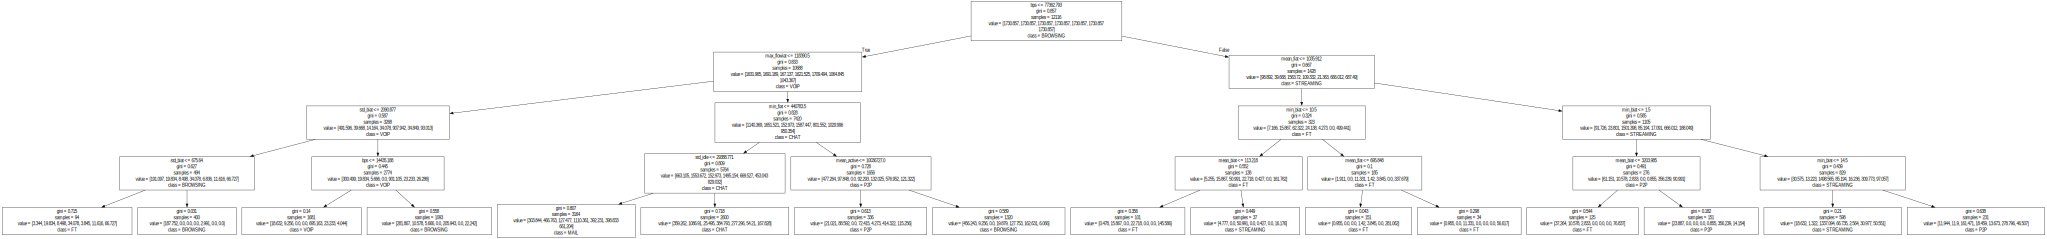

In [20]:
from sklearn import tree

classes=list(map(bytes.decode, ds.cls_list))[:7]

print(
    tree.export_text(
        min,
        feature_names=X.columns,
        class_names=classes,
    )
)

from graphviz import Source
from sklearn import tree
graph = Source( tree.export_graphviz(min, out_file=None, feature_names=X.columns, class_names=classes))
from IPython.display import SVG
SVG(graph.pipe(format='svg'))